# Web Voyager
[WebVoyager](https://arxiv.org/abs/2401.13919) 는 마우스와 키보드를 제어할 수 있는 시각 지원 웹 브라우징 에이전트입니다.

이 에이전트는 각 턴마다 주석이 달린 브라우저 스크린샷을 보고 다음 단계를 선택하는 방식으로 작동합니다. 에이전트 아키텍처는 기본적인 추론 및 행동(ReAct) 루프입니다. 
이 에이전트의 독특한 측면은 다음과 같습니다:
- 에이전트의 UI 어포던스 역할을 하는 [Set-of-Marks](https://som-gpt4v.github.io/)와 같은 이미지 주석을 사용한다는 점입니다.
- 마우스와 키보드를 모두 제어할 수 있는 도구를 사용하여 브라우저에 적용합니다.

전체적인 디자인은 다음과 같습니다:

<!-- ![보이저 이미지](./img/web-voyager.excalidraw.png) -->
<img src="./img/web-voyager.excalidraw.png" width="50%">

In [1]:
!pip install -U --quiet langgraph langchain_openai

In [2]:
# Optional: add tracing to visualize the agent trajectories
import os
from getpass import getpass


def _getpass(env_var: str):
    if not os.environ.get(env_var):
        os.environ[env_var] = getpass(f"{env_var}=")

_getpass("OPENAI_API_KEY")

#### playwright 설치하기
[playwright](https://playwright.dev/)

In [3]:
!pip install --upgrade --quiet  playwright > /dev/null
!playwright install

In [4]:
import nest_asyncio

# This is just required for running async playwright in a Jupyter notebook
nest_asyncio.apply()

## 그래프 상태 정의하기

상태는 그래프의 각 노드에 입력을 제공합니다.

이 경우 에이전트는 웹 페이지 개체(브라우저 내), 주석이 달린 이미지 + 바운딩 박스, 사용자의 초기 요청, 에이전트 스크래치 패드, 시스템 프롬프트 및 기타 정보가 포함된 메시지를 추적합니다.

In [6]:
from typing import List, Optional, TypedDict

from langchain_core.messages import BaseMessage, SystemMessage
from playwright.async_api import Page


class BBox(TypedDict):
    x: float
    y: float
    text: str
    type: str
    ariaLabel: str


class Prediction(TypedDict):
    action: str
    args: Optional[List[str]]


# 에이전트가 실행을 진행하면서 나타내는 상태를 나타냅니다.
class AgentState(TypedDict):
    page: Page  # Playwright 웹 페이지는 웹 환경과 상호작용할 수 있게 합니다.
    input: str  # 사용자 요청
    img: str  # base64로 인코딩된 스크린샷
    bboxes: List[BBox]  # 브라우저 주석 기능에서 얻은 경계 상자들
    prediction: Prediction  # 에이전트의 출력
    # 중간 단계들을 포함하는 시스템 메시지(또는 메시지들)
    scratchpad: List[BaseMessage]
    observation: str  # 도구로부터의 가장 최근 응답

## 도구 정의하기

AI에게는 6가지 간단한 도구가 있습니다:

1. (레이블이 지정된 상자에서) 클릭
2. 타자 치기
3. 스크롤
4. Wait
5. 뒤로 가기
6. 검색 엔진으로 이동(Google)


아래에서는 이를 함수로 정의합니다:

In [7]:
import asyncio
import platform


async def click(state: AgentState):
    # - Click [Numerical_Label]
    page = state["page"]
    click_args = state["prediction"]["args"]
    if click_args is None or len(click_args) != 1:
        return f"숫자 {click_args}로 표시된 bounding box를 클릭하지 못했습니다."
    bbox_id = click_args[0]
    bbox_id = int(bbox_id)
    try:
        bbox = state["bboxes"][bbox_id]
    except Exception:
        return f"Error: no bbox for : {bbox_id}"
    x, y = bbox["x"], bbox["y"]
    await page.mouse.click(x, y)
    # TODO: In the paper, they automatically parse any downloaded PDFs
    # We could add something similar here as well and generally
    # improve response format.
    return f"Clicked {bbox_id}"


async def type_text(state: AgentState):
    page = state["page"]
    type_args = state["prediction"]["args"]
    if type_args is None or len(type_args) != 2:
        return (
            f"숫자 {type_args}로 레이블이 지정된 bounding box의 요소를 입력하지 못했습니다 "
        )
    bbox_id = type_args[0]
    bbox_id = int(bbox_id)
    bbox = state["bboxes"][bbox_id]
    x, y = bbox["x"], bbox["y"]
    text_content = type_args[1]
    await page.mouse.click(x, y)
    # Check if MacOS
    select_all = "Meta+A" if platform.system() == "Darwin" else "Control+A"
    await page.keyboard.press(select_all)
    await page.keyboard.press("Backspace")
    await page.keyboard.type(text_content)
    await page.keyboard.press("Enter")
    return f"Typed {text_content} and submitted"


async def scroll(state: AgentState):
    page = state["page"]
    scroll_args = state["prediction"]["args"]
    if scroll_args is None or len(scroll_args) != 2:
        return "인수가 잘못되어 스크롤하지 못했습니다."

    target, direction = scroll_args

    if target.upper() == "WINDOW":
        # Not sure the best value for this:
        scroll_amount = 500
        scroll_direction = (
            -scroll_amount if direction.lower() == "up" else scroll_amount
        )
        await page.evaluate(f"window.scrollBy(0, {scroll_direction})")
    else:
        # Scrolling within a specific element
        scroll_amount = 200
        target_id = int(target)
        bbox = state["bboxes"][target_id]
        x, y = bbox["x"], bbox["y"]
        scroll_direction = (
            -scroll_amount if direction.lower() == "up" else scroll_amount
        )
        await page.mouse.move(x, y)
        await page.mouse.wheel(0, scroll_direction)

    return f"Scrolled {direction} in {'window' if target.upper() == 'WINDOW' else 'element'}"


async def wait(state: AgentState):
    sleep_time = 5
    await asyncio.sleep(sleep_time)
    return f"Waited for {sleep_time}s."


async def go_back(state: AgentState):
    page = state["page"]
    await page.go_back()
    return f"Navigated back a page to {page.url}."


async def to_google(state: AgentState):
    page = state["page"]
    await page.goto("https://www.google.com/")
    return "google.com으로 이동했습니다."

## 에이전트 정의

에이전트는 멀티모달 모델에 의해 구동되며 각 단계에 대해 수행할 작업을 결정합니다. 에이전트는 몇 가지 실행 가능한 객체로 구성됩니다:

1. 현재 페이지에 바운딩 박스로 주석을 다는 `mark_page` 함수
2. 사용자 질문, 주석이 달린 이미지 및 AI 스크래치 패드를 보유하는 프롬프트
3. 다음 단계를 결정하기 위한 GPT-4V
4. 액션을 추출하기 위한 파싱 로직


먼저 어노테이션 단계를 정의해 보겠습니다:
#### 브라우저 주석

이 기능은 모든 버튼, 입력, 텍스트 영역 등에 번호가 매겨진 바운딩 박스로 주석을 달 수 있습니다. 그러면 GPT-4V는 바운딩 박스만 참조하면 됩니다.
만 참조하면 되므로 전체 작업의 복잡성이 줄어듭니다.

In [8]:
import base64

from langchain_core.runnables import chain as chain_decorator

# Some javascript we will run on each step
# to take a screenshot of the page, select the
# elements to annotate, and add bounding boxes
with open("mark_page.js") as f:
    mark_page_script = f.read()


@chain_decorator
async def mark_page(page):
    await page.evaluate(mark_page_script)
    for _ in range(10):
        try:
            bboxes = await page.evaluate("markPage()")
            break
        except Exception:
            # May be loading...
            asyncio.sleep(3)
    screenshot = await page.screenshot()
    # Ensure the bboxes don't follow us around
    await page.evaluate("unmarkPage()")
    return {
        "img": base64.b64encode(screenshot).decode(),
        "bboxes": bboxes,
    }

#### 에이전트 정의

이제 프롬프트, llm 및 출력 파서를 사용하여 에이전트를 완성하기 위해 이 함수를 작성해 보겠습니다.

In [9]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import ChatOpenAI


async def annotate(state):
    marked_page = await mark_page.with_retry().ainvoke(state["page"])
    return {**state, **marked_page}


def format_descriptions(state):
    labels = []
    for i, bbox in enumerate(state["bboxes"]):
        text = bbox.get("ariaLabel") or ""
        if not text.strip():
            text = bbox["text"]
        el_type = bbox.get("type")
        labels.append(f'{i} (<{el_type}/>): "{text}"')
    bbox_descriptions = "\nValid Bounding Boxes:\n" + "\n".join(labels)
    return {**state, "bbox_descriptions": bbox_descriptions}


def parse(text: str) -> dict:
    action_prefix = "Action: "
    if not text.strip().split("\n")[-1].startswith(action_prefix):
        return {"action": "retry", "args": f"Could not parse LLM Output: {text}"}
    action_block = text.strip().split("\n")[-1]

    action_str = action_block[len(action_prefix) :]
    split_output = action_str.split(" ", 1)
    if len(split_output) == 1:
        action, action_input = split_output[0], None
    else:
        action, action_input = split_output
    action = action.strip()
    if action_input is not None:
        action_input = [
            inp.strip().strip("[]") for inp in action_input.strip().split(";")
        ]
    return {"action": action, "args": action_input}


# Will need a later version of langchain to pull
# this image prompt template
prompt = hub.pull("wfh/web-voyager")

In [10]:
print(prompt.messages[0].prompt[0].template)

Imagine you are a robot browsing the web, just like humans. Now you need to complete a task. In each iteration, you will receive an Observation that includes a screenshot of a webpage and some texts. This screenshot will
feature Numerical Labels placed in the TOP LEFT corner of each Web Element. Carefully analyze the visual
information to identify the Numerical Label corresponding to the Web Element that requires interaction, then follow
the guidelines and choose one of the following actions:

1. Click a Web Element.
2. Delete existing content in a textbox and then type content.
3. Scroll up or down.
4. Wait 
5. Go back
7. Return to google to start over.
8. Respond with the final answer

Correspondingly, Action should STRICTLY follow the format:

- Click [Numerical_Label] 
- Type [Numerical_Label]; [Content] 
- Scroll [Numerical_Label or WINDOW]; [up or down] 
- Wait 
- GoBack
- Google
- ANSWER; [content]

Key Guidelines You MUST follow:

* Action guidelines *
1) Execute only one actio

In [11]:
llm = ChatOpenAI(model="gpt-4o", max_tokens=4096)
agent = annotate | RunnablePassthrough.assign(
    prediction=format_descriptions | prompt | llm | StrOutputParser() | parse
)

## 그래프 정의하기

대부분의 중요한 로직을 만들었습니다. 도구가 호출된 후 그래프 상태를 업데이트하는 데 도움이 되는 함수를 하나 더 정의해야 합니다.

In [12]:
import re


def update_scratchpad(state: AgentState):
    """도구가 호출된 후, 에이전트가 이전 단계를 인식할 수 있도록
    스크래치 패드를 업데이트하여 에이전트가 이전 단계를 인식하도록 합니다."""
    old = state.get("scratchpad")
    if old:
        txt = old[0].content
        last_line = txt.rsplit("\n", 1)[-1]
        step = int(re.match(r"\d+", last_line).group()) + 1
    else:
        txt = "Previous action observations:\n"
        step = 1
    txt += f"\n{step}. {state['observation']}"

    return {**state, "scratchpad": [SystemMessage(content=txt)]}

이제 모든 것을 그래프로 구성할 수 있습니다

In [13]:
from langchain_core.runnables import RunnableLambda

from langgraph.graph import END, StateGraph

graph_builder = StateGraph(AgentState)


graph_builder.add_node("agent", agent)
graph_builder.set_entry_point("agent")

graph_builder.add_node("update_scratchpad", update_scratchpad)
graph_builder.add_edge("update_scratchpad", "agent")

tools = {
    "Click": click,
    "Type": type_text,
    "Scroll": scroll,
    "Wait": wait,
    "GoBack": go_back,
    "Google": to_google,
}


for node_name, tool in tools.items():
    graph_builder.add_node(
        node_name,
        # The lambda ensures the function's string output is mapped to the "observation"
        # key in the AgentState
        RunnableLambda(tool) | (lambda observation: {"observation": observation}),
    )
    # Always return to the agent (by means of the update-scratchpad node)
    graph_builder.add_edge(node_name, "update_scratchpad")


def select_tool(state: AgentState):
    # Any time the agent completes, this function
    # is called to route the output to a tool or
    # to the end user.
    action = state["prediction"]["action"]
    if action == "ANSWER":
        return END
    if action == "retry":
        return "agent"
    return action


graph_builder.add_conditional_edges("agent", select_tool)

graph = graph_builder.compile()

## 에이전트 실행

이제 전체 에이전트 실행기를 만들었으니 몇 가지 질문에 대해 실행할 수 있습니다! "google.com"에서 브라우저를 시작한 다음 나머지는 브라우저에 맡기겠습니다.

아래는 단계를 노트북에 인쇄하고 중간 스크린샷을 표시하는 데 도움이 되는 도우미 기능입니다

In [14]:
from IPython import display
from playwright.async_api import async_playwright

browser = await async_playwright().start()
# We will set headless=False so we can watch the agent navigate the web.
browser = await browser.chromium.launch(headless=False, args=None)
page = await browser.new_page()
_ = await page.goto("https://www.google.com")


async def call_agent(question: str, page, max_steps: int = 150):
    event_stream = graph.astream(
        {
            "page": page,
            "input": question,
            "scratchpad": [],
        },
        {
            "recursion_limit": max_steps,
        },
    )
    final_answer = None
    steps = []
    async for event in event_stream:
        # We'll display an event stream here
        if "agent" not in event:
            continue
        pred = event["agent"].get("prediction") or {}
        action = pred.get("action")
        action_input = pred.get("args")
        display.clear_output(wait=False)
        steps.append(f"{len(steps) + 1}. {action}: {action_input}")
        print("\n".join(steps))
        display.display(display.Image(base64.b64decode(event["agent"]["img"])))
        if "ANSWER" in action:
            final_answer = action_input[0]
            break
    return final_answer

1. Type: ['6', '미국 대선 날짜']
2. ANSWER;: ['The 2024 US presidential election is scheduled for November 5, 2024.']


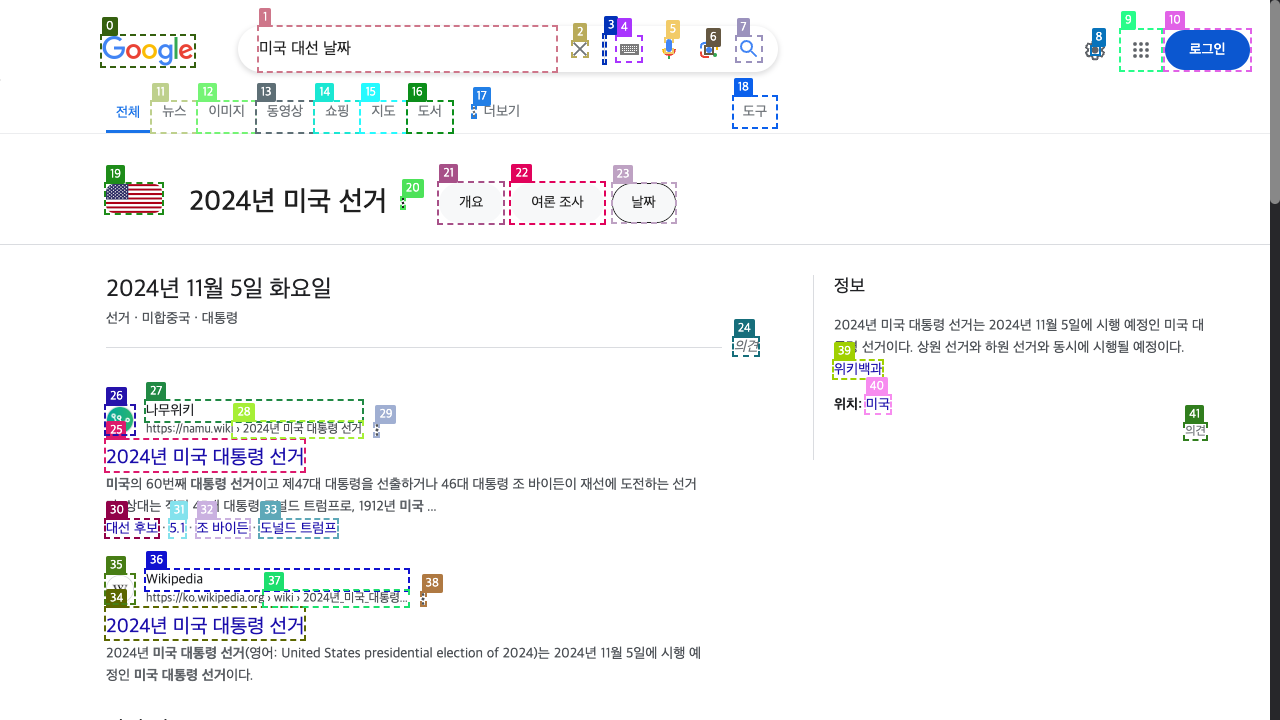

Final response: The 2024 US presidential election is scheduled for November 5, 2024.


In [15]:
res = await call_agent("미국 대선 날짜", page)
print(f"Final response: {res}")

1. Type: ['1', 'langchain의 가장 최신 블로그 글']
2. Click: ['26']
3. Scroll: ['WINDOW', 'down']
4. Scroll: ['WINDOW', 'down']
5. ANSWER;: ['The most recent blog post about LangChain is titled "LLM을 쓰려면 역시 LangChain 3편" and was published on 2024. 4. 18. 14:21.']


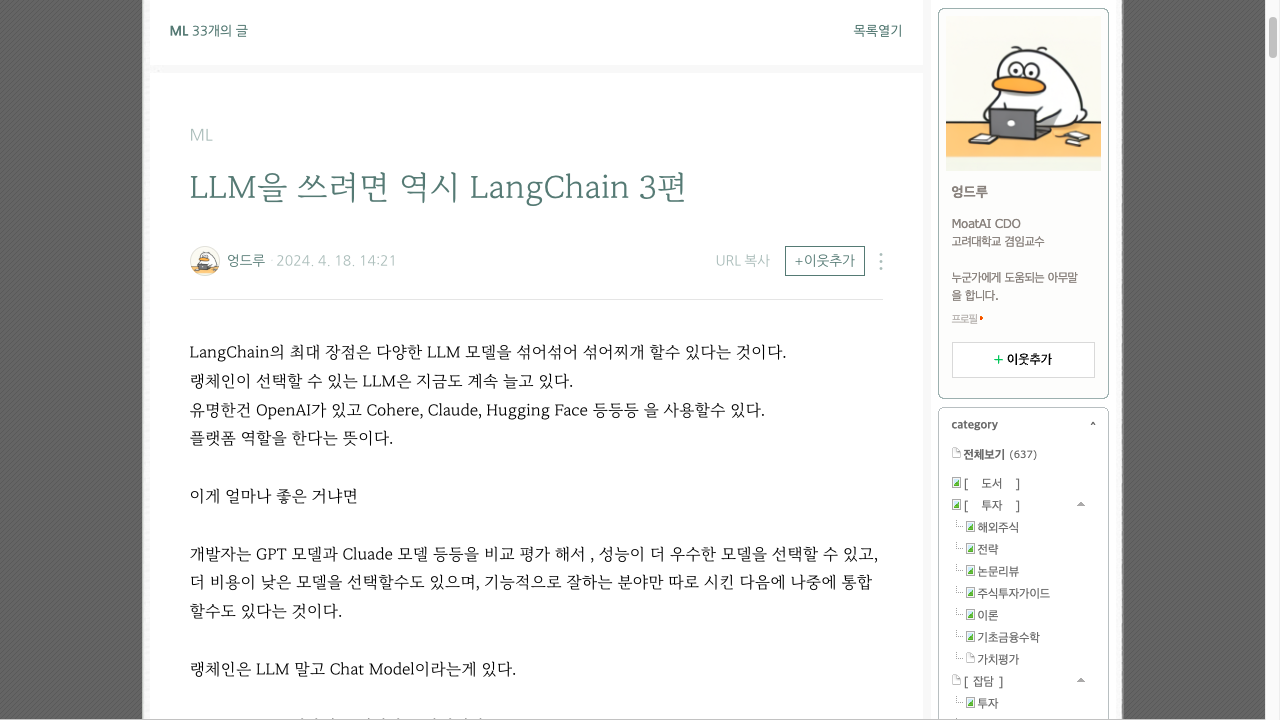

Final response: The most recent blog post about LangChain is titled "LLM을 쓰려면 역시 LangChain 3편" and was published on 2024. 4. 18. 14:21.


In [16]:
res = await call_agent("langchain의 가장 최신 블로그 글 찾아줘", page)
print(f"Final response: {res}")